# Packages Import

In [3]:
import tensorflow as tf
from pymongo import  MongoClient
import json
import requests
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from apscheduler.schedulers.blocking import BlockingScheduler

# Connexion Spark MongoDB

In [4]:
import findspark
findspark.init(spark_home='D:\spark')
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext

In [6]:
input_uri = "mongodb://localhost:27017/Bitcoin.data"
output_uri = "mongodb://localhost:27017/Bitcoin.data"

conf=SparkConf()
conf.set('spark.mongodb.input.uri', input_uri)
conf.set('spark.mongodb.output.uri', output_uri)
conf.set('spark.mongodb.input.sampleSize', 50000)

In [8]:
sc=SparkContext.getOrCreate(conf=conf)
sqlContext=SQLContext(sc)
df=sqlContext.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- price_usd: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [9]:
df.show(5)

+--------------------+------------------+--------------------+
|                 _id|         price_usd|           timestamp|
+--------------------+------------------+--------------------+
|[6009634838b90e41...|32788.853887854064|2021-01-21 12:19:...|
|[6009634838b90e41...| 32768.19062723364|2021-01-21 12:19:...|
|[6009636438b90e41...| 32769.62215628142|2021-01-21 12:20:...|
|[6009636b38b90e41...|32765.258738309698|2021-01-21 12:20:...|
|[6009637338b90e41...|32737.118081120694|2021-01-21 12:20:...|
+--------------------+------------------+--------------------+
only showing top 5 rows



In [44]:
df.count()

610

In [45]:
df_p=df.toPandas()
df_p.head()

,_id,price_usd,timestamp
0,"(6009634838b90e41dcf0e0f8,)",32788.853888,2021-01-21 12:19:27.476
1,"(6009634838b90e41dcf0e0f9,)",32768.190627,2021-01-21 12:19:35.246
2,"(6009636438b90e41dcf0e0fa,)",32769.622156,2021-01-21 12:20:03.349
3,"(6009636b38b90e41dcf0e0fb,)",32765.258738,2021-01-21 12:20:10.362
4,"(6009637338b90e41dcf0e0fc,)",32737.118081,2021-01-21 12:20:17.972


# Model

In [23]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

In [24]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [25]:
def normalise_zero_base(df):
    scaler = MinMaxScaler()
    return scaler.fit_transform(df.iloc[:,0:6])

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [26]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp)
    return np.array(window_data)

In [27]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    
    train_data, test_data = train_test_split(df, test_size=test_size)

    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)

    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [28]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    print('build_lstm_model')
    print(input_data.shape)
    model = tf.keras.Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    print('>>>>>>>>>> ')
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [33]:
def prepare_hist(df):
    df = df.toPandas()
    df = df[["timestamp", "price_usd"]]
    df = df.set_index("timestamp")
    return df

In [39]:
#sched = BlockingScheduler()
#@sched.scheduled_job('interval', seconds=60)#@sched.scheduled_job('cron', day_of_week='mon-fri', hour=10)
def all_programme(df):
    #global hist
    hist= prepare_hist(df)
    hist=hist.iloc[-400:]
    
    print('***********************prepare data**************************')
    train, test = train_test_split(hist, test_size=0.2)
    
    print('*********************train, test*******************************')
    train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col='price_usd', window_len=5)

    X_train = np.asarray(X_train).astype(np.float32)
    y_train=np.asarray(y_train).astype(np.float32)

    model = build_lstm_model(X_train, output_size=1)
    
    print('******************lancer_training*************************')
    history = model.fit( X_train, y_train, epochs=20, batch_size=32, verbose=1, shuffle=True) 
    
    print('***************************tester************************')
    targets = test['price_usd'][5:]
    preds = model.predict(X_test).squeeze()
    print('mse:',mean_absolute_error(preds, y_test))
    preds = test['price_usd'].values[:-5] * (preds + 1)
    preds = pd.Series(index=targets.index, data=preds)
    
    print('***************************Plot************************')
    line_plot(targets, preds, 'actual', 'prediction', lw=3)
    
    print('****************to_save*************')
    model.save('C:\\Users\\Utilisateur\\Desktop\\CIISIBD\\S9\\7-BIG_DATA_Applications\\PROJET\\Spark_NoteBook\\my_Model.h5')
    print('*<saved>*')

#sched.start()

***********************prepare data**************************
*********************train, test*******************************
build_lstm_model
(315, 5, 1)
>>>>>>>>>> 
******************lancer_training*************************
Epoch 1/20
315/315 [==============================]315/315 [==============================] - 1s 3ms/step - loss: 3.8457e-04

Epoch 2/20
315/315 [==============================]315/315 [==============================] - 0s 435us/step - loss: 2.7983e-04

Epoch 3/20
315/315 [==============================]315/315 [==============================] - 0s 400us/step - loss: 1.5676e-04

Epoch 4/20
315/315 [==============================]315/315 [==============================] - 0s 432us/step - loss: 1.5980e-04

Epoch 5/20
315/315 [==============================]315/315 [==============================] - 0s 448us/step - loss: 1.1716e-04

Epoch 6/20
315/315 [==============================]315/315 [==============================] - 0s 441us/step - loss: 9.5757e-05

Epoch 7/

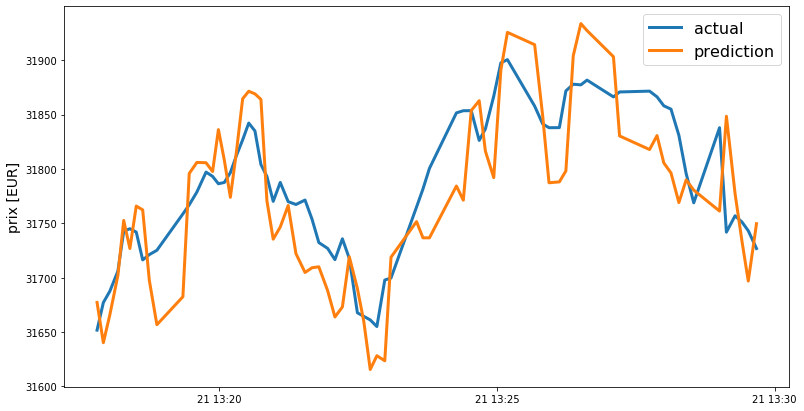

In [40]:
all_programme(df)

# Prediction

In [43]:
from tensorflow.python.keras.models import load_model
model = load_model('C:\\Users\\Utilisateur\\Desktop\\CIISIBD\\S9\\7-BIG_DATA_Applications\\PROJET\\Spark_NoteBook\\my_Model.h5')

In [106]:
from datetime import datetime

d=prepare_hist(df)
t = d.index.values.astype(np.int64)[-1]
tmp = int(t/1000000000)

future_dates=list()
for i in range(120):
    future_dates.append(datetime.fromtimestamp(tmp+(i*10)))

future_data = pd.DataFrame(future_dates,columns={'timestamp'})
future_data["price_usd"]=np.nan
future_data=future_data.set_index("timestamp")
future_data.head(5)

,price_usd
timestamp,
2021-01-21 14:12:14,NaN
2021-01-21 14:12:24,NaN
2021-01-21 14:12:34,NaN
2021-01-21 14:12:44,NaN
2021-01-21 14:12:54,NaN


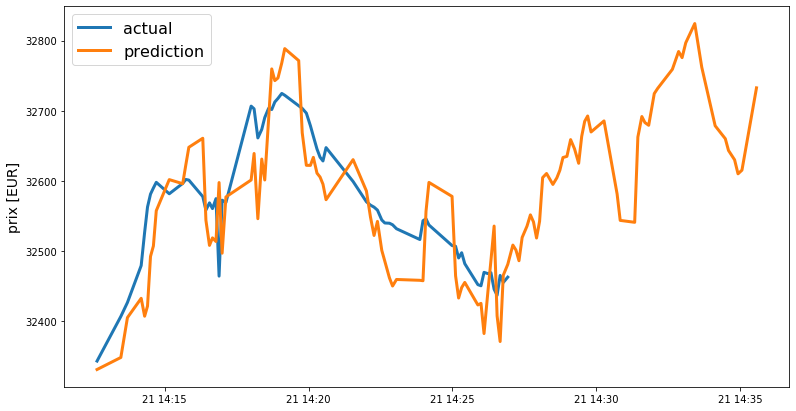

In [74]:
actual = df[-60:]
preds = model.predict(future_data).squeeze()
line_plot(actual, preds, 'actual', 'prediction', lw=3)